In [53]:
#librerias
import pandas as pd
from dateutil.easter import easter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Time**

In [54]:
df_time = pd.read_csv("../data/raw/time.csv")
df_time = df_time.sort_index()
df_time.head()

,ID_Date,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek
0,202201,31,5,7,21,10,0
1,202202,28,1,7,20,8,0
2,202203,31,1,3,23,8,0
3,202204,30,4,5,22,8,1
4,202205,31,6,1,21,10,0


**Web**

In [55]:
df_web=pd.read_csv('../data/raw/web.csv')
df_web['ID_Date'] = pd.to_datetime(df_web['ID_Date'], format='%Y%m')
df_web.set_index('ID_Date', inplace=True)
df_web.head()

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
ID_Date,,,,,,,,,,,
2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


**Offline**

In [56]:
path='../data/raw/offline.csv'
df_off=pd.read_csv(path)
df_off['ID_Date'] = pd.to_datetime(df_off['ID_Date'], format='%Y%m')
df_off.set_index('ID_Date', inplace=True)
df_off.head()

,Visit_Store,Mercado,Sales,Complementos,Ropa_hombre,Zapatos,Ropa_Mujer,Home,Interior,Otros,Ticket_medio
ID_Date,,,,,,,,,,,
2022-01-01,5516,76331,1299,115,270,273,444,131,60,6,68
2022-02-01,6769,97646,1752,155,393,286,689,179,42,8,86
2022-03-01,6249,111510,1897,148,442,333,693,249,30,2,92
2022-04-01,6507,100269,1546,110,371,297,591,154,23,0,87
2022-05-01,7183,113667,1784,138,411,374,635,187,38,1,83


**Inversion**

In [57]:
path='../data/raw/inv.csv'
df_inv=pd.read_csv(path)
df_inv['ID_Date'] = pd.to_datetime(df_inv['ID_Date'], format='%Y%m')
df_inv.set_index('ID_Date', inplace=True)
df_inv.head()

,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total
ID_Date,,,,,,,,,,
2022-01-01,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,574600.14
2022-02-01,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,916515.08
2022-03-01,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,367522.47
2022-04-01,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,941187.91
2022-05-01,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,746390.17


**Mercado Sarima**

In [58]:
path='../data/sarima/pred_mercado_sarima.csv'
df_pred_mercado_sarima=pd.read_csv(path)
df_pred_mercado_sarima.head()

,Fecha,Mercado
0,2025-01-01,98634.000000
1,2025-02-01,102528.677793
2,2025-03-01,117652.495742
3,2025-04-01,113512.663871
4,2025-05-01,125159.943305


# Carga y Selección Datos

**Estrategia para preparar las variables del modelo de atribución (2025-2026)**

Para realizar las simulaciones del modelo de atribución en 2025 y 2026, se aplicarán diferentes enfoques según la naturaleza de cada variable:

1. `Mercado`
- **Método**: Proyección con modelo SARIMA.
- **Justificación**: La serie muestra estacionalidad clara y buena capacidad de ajuste.

 2. `DirectTraffic` y `Unique_visitors`
- **Método**: Media mensual histórica.
- **Justificación**: Los modelos SARIMA no capturan bien la tendencia futura debido a la poca capacidad de generalización y al ruido en los últimos datos. La media mensual por mes (ej. media de todos los eneros, febreros, etc.) proporciona valores estables.


 3. Variables de calendario (`working_days`, `Dias_fines_semana`, `Dia_inicio_mes`, `Easterweek`)
- **Método**: Generación automática con base en el calendario.

In [59]:
# Dataframe - índice las fechas desde 2025-01 hastas 2026-16
fechas_futuras = pd.date_range(start='2025-01-01', end='2026-12-01', freq='MS')
df_futuro = pd.DataFrame(index=fechas_futuras)

## Variables Exógenas Tiempo

In [60]:
#  Días del mes
df_futuro['Dias_mes'] = df_futuro.index.days_in_month

In [61]:
# Obtener datos de 2024 como copia segura
df_2024 = df_time[df_time['ID_Date'].astype(str).str.startswith('2024')].copy()

# Calcular días de inicio de mes +1 y +2
df_2024['Dia_inicio_mes+1'] = df_2024['Dia_inicio_mes'].apply(lambda x: 1 if x == 7 else x + 1)
df_2024['Dia_inicio_mes+2'] = df_2024['Dia_inicio_mes+1'].apply(lambda x: 1 if x == 7 else x + 1)

# Extraer listas
dias_2025 = df_2024.loc[df_2024['ID_Date'].between(202401, 202412), 'Dia_inicio_mes+1'].tolist()
dias_2026 = df_2024.loc[df_2024['ID_Date'].between(202401, 202412), 'Dia_inicio_mes+2'].tolist()

# Asegurar que hay 12 valores
assert len(dias_2025) == 12
assert len(dias_2026) == 12

# Asignar a df_futuro
df_futuro.loc['2025-01-01':'2025-12-01', 'Dia_inicio_mes'] = dias_2025
df_futuro.loc['2026-01-01':'2026-12-01', 'Dia_inicio_mes'] = dias_2026

In [62]:
# Días laborales del mes
df_futuro['working_days'] = df_futuro.index.to_series().apply(
    lambda x: pd.date_range(start=x, end=x + pd.offsets.MonthEnd(0), freq='B').size)

In [63]:
#  Días de fin de semana del mes:dias_mes-dias_trabajo
df_futuro['Dias_fines_semana'] = df_futuro['Dias_mes'] - df_futuro['working_days']

In [64]:
# Easterweek =1 si es Pascua (logrado con libreria python)
df_futuro['Easterweek'] = df_futuro.index.to_series().apply(
    lambda d: 1 if easter(d.year).month == d.month else 0
)

In [65]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek
2025-01-01,31,1.0,23,8,0
2025-02-01,28,4.0,20,8,0
2025-03-01,31,4.0,21,10,0
2025-04-01,30,7.0,22,8,1
2025-05-01,31,2.0,22,9,0


## Variables Unique Visitors y DirectTraffic

**Unique_Visitors**

In [66]:
df_web['year'] = df_web.index.year
df_web['month'] = df_web.index.month

# Predecir cada mes de 2025 usando datos reales de 2022-2024
predicciones_2025 = []
for mes in range(1, 13):
    datos_historicos = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2022, 2023, 2024]))
    ]['Unique_visitors']
    
    prediccion = datos_historicos.mean()
    predicciones_2025.append(prediccion)

fechas_2025 = pd.date_range(start="2025-01-01", end="2025-12-01", freq="MS")
df_2025 = pd.DataFrame({'Fecha': fechas_2025, 'Prediccion_Unique_visitors': predicciones_2025})

#  Predecir cada mes de 2026 usando 2023, 2024 y la predicción de 2025
predicciones_2026 = []
for mes in range(1, 13):
    datos_2023_2024 = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2023, 2024]))
    ]['Unique_visitors']
    
    pred_2025 = df_2025[df_2025['Fecha'].dt.month == mes]['Prediccion_Unique_visitors'].values[0]
    
    datos_combinados = list(datos_2023_2024) + [pred_2025]
    prediccion_2026 = sum(datos_combinados) / len(datos_combinados)
    predicciones_2026.append(prediccion_2026)

fechas_2026 = pd.date_range(start="2026-01-01", end="2026-12-01", freq="MS")
df_2026 = pd.DataFrame({'Fecha': fechas_2026, 'Prediccion_Unique_visitors': predicciones_2026})

# 5. Unir ambos años
df_pred_UV = pd.concat([df_2025, df_2026])

# Mostrar resultado
df_pred_UV.head()

,Fecha,Prediccion_Unique_visitors
0,2025-01-01,263567.000000
1,2025-02-01,304353.333333
2,2025-03-01,271983.333333
3,2025-04-01,236862.000000
4,2025-05-01,257969.000000


In [67]:
# Arreglar índice de fechas de df_pred_final
df_pred_UV.reset_index(inplace=True, drop=True)  # quitar índice roto si lo hay
df_pred_UV['Fecha'] = pd.to_datetime(df_pred_UV['Fecha'])  # convertir bien
df_pred_UV.set_index('Fecha', inplace=True)  # volver a poner como índice

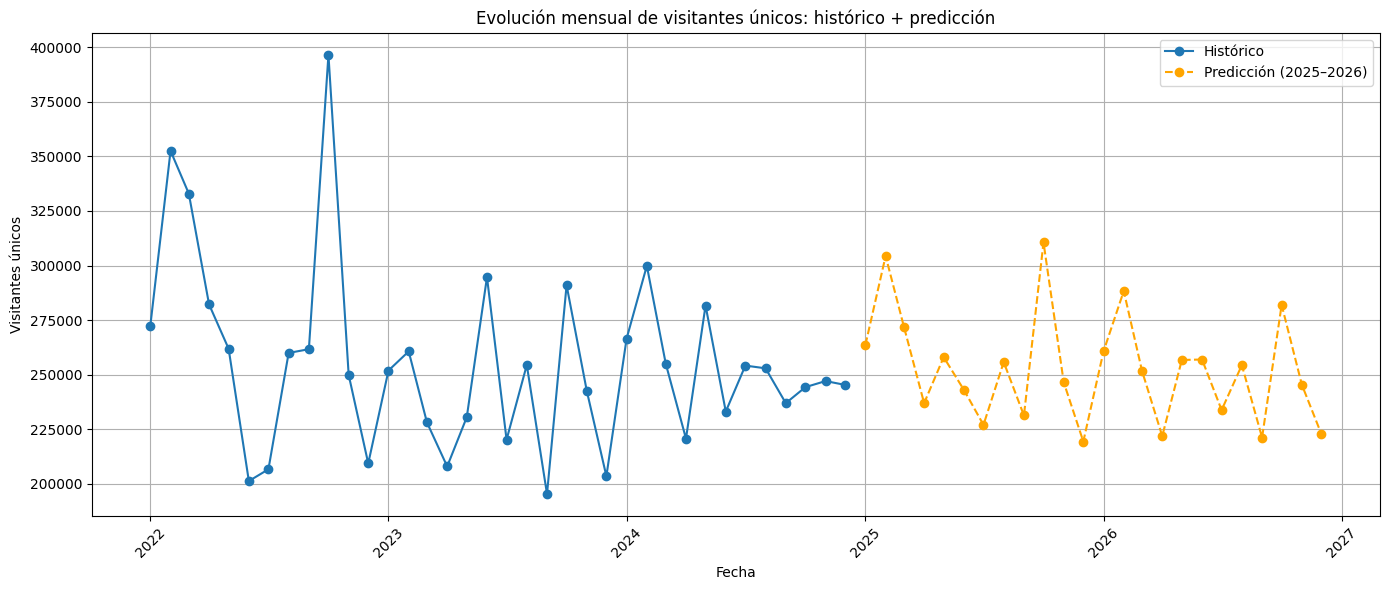

In [68]:
plt.figure(figsize=(14, 6))

# Histórico
plt.plot(df_web.index, df_web['Unique_visitors'], label='Histórico', marker='o')

# Predicción 2025-2026
plt.plot(df_pred_UV.index, df_pred_UV['Prediccion_Unique_visitors'], label='Predicción (2025–2026)', linestyle='--', marker='o', color='orange')

plt.title('Evolución mensual de visitantes únicos: histórico + predicción')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [69]:
# Cambiar nombre de la columna si hace falta
df_pred_UV.rename(columns={'Prediccion_Unique_visitors': 'Unique_visitors'}, inplace=True)
df_futuro = df_futuro.join(df_pred_UV[['Unique_visitors']], how='left')
df_futuro.head()


,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors
2025-01-01,31,1.0,23,8,0,263567.000000
2025-02-01,28,4.0,20,8,0,304353.333333
2025-03-01,31,4.0,21,10,0,271983.333333
2025-04-01,30,7.0,22,8,1,236862.000000
2025-05-01,31,2.0,22,9,0,257969.000000


In [70]:
predicciones_2025_DT = []
for mes in range(1, 13):
    datos_historicos = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2022, 2023, 2024]))
    ]['DirectTraffic']
    
    prediccion = datos_historicos.mean()
    predicciones_2025_DT.append(prediccion)

fechas_2025 = pd.date_range(start="2025-01-01", end="2025-12-01", freq="MS")
df_2025_DT = pd.DataFrame({'Fecha': fechas_2025, 'Prediccion_DirectTraffic': predicciones_2025_DT})


predicciones_2026_DT = []
for mes in range(1, 13):
    datos_2023_2024 = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2023, 2024]))
    ]['DirectTraffic']
    
    pred_2025 = df_2025_DT[df_2025_DT['Fecha'].dt.month == mes]['Prediccion_DirectTraffic'].values[0]
    
    datos_combinados = list(datos_2023_2024) + [pred_2025]
    prediccion = sum(datos_combinados) / len(datos_combinados)
    predicciones_2026_DT.append(prediccion)

fechas_2026 = pd.date_range(start="2026-01-01", end="2026-12-01", freq="MS")
df_2026_DT = pd.DataFrame({'Fecha': fechas_2026, 'Prediccion_DirectTraffic': predicciones_2026_DT})


df_pred_DT = pd.concat([df_2025_DT, df_2026_DT], ignore_index=True)
df_pred_DT.set_index('Fecha', inplace=True)

df_pred_DT.head()

,Prediccion_DirectTraffic
Fecha,
2025-01-01,86220.333333
2025-02-01,92794.666667
2025-03-01,82812.000000
2025-04-01,72764.666667
2025-05-01,72812.333333


**DirectTraffic**

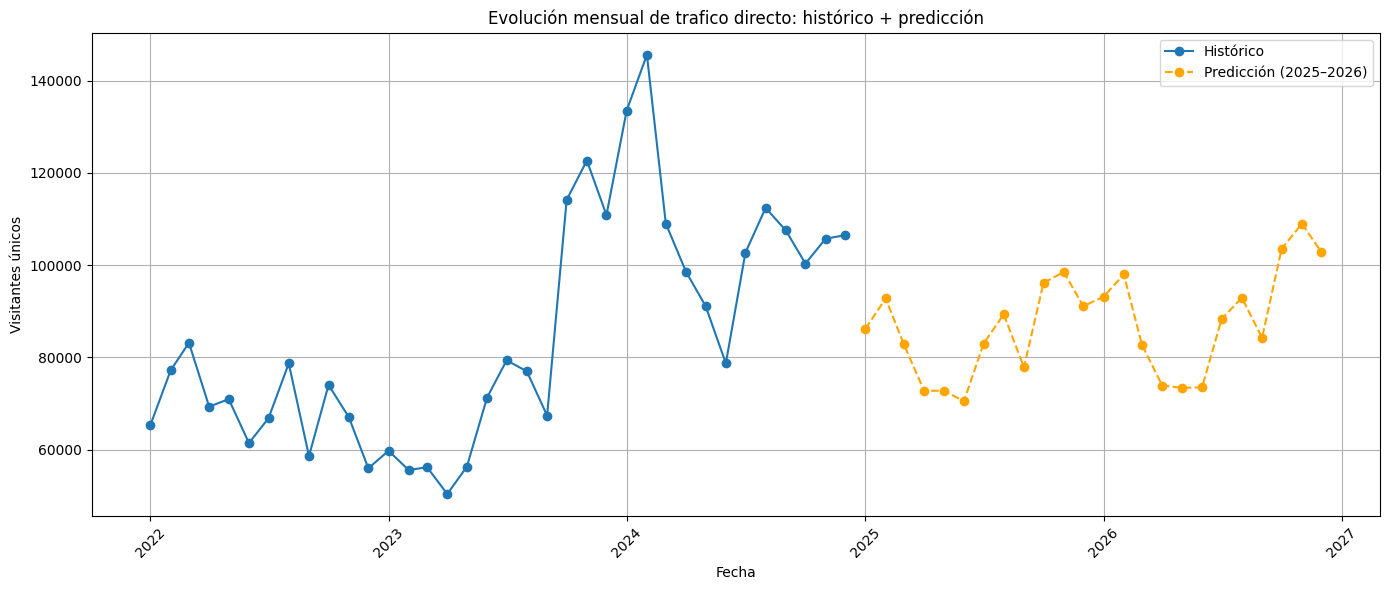

In [71]:
plt.figure(figsize=(14, 6))

# Histórico
plt.plot(df_web.index, df_web['DirectTraffic'], label='Histórico', marker='o')

# Predicción 2025-2026
plt.plot(df_pred_DT.index, df_pred_DT['Prediccion_DirectTraffic'], label='Predicción (2025–2026)', linestyle='--', marker='o', color='orange')

plt.title('Evolución mensual de trafico directo: histórico + predicción')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
df_pred_DT.rename(columns={'Prediccion_DirectTraffic': 'DirectTraffic'}, inplace=True)
df_futuro = df_futuro.join(df_pred_DT[['DirectTraffic']], how='left')
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333


## Variable Mercado

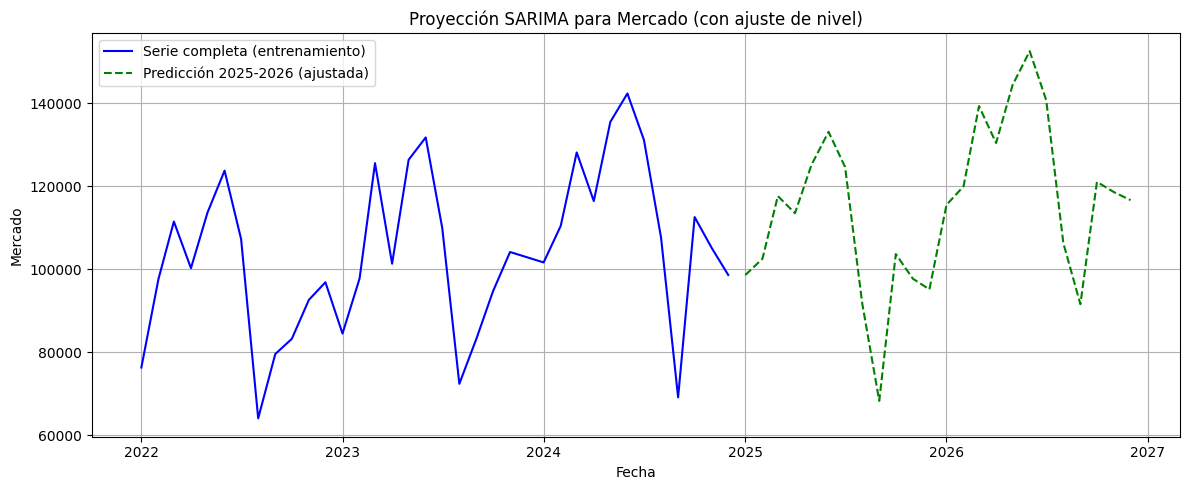

In [73]:
df_pred_mercado_sarima.head()

,Fecha,Mercado
0,2025-01-01,98634.000000
1,2025-02-01,102528.677793
2,2025-03-01,117652.495742
3,2025-04-01,113512.663871
4,2025-05-01,125159.943305


In [74]:
df_pred_mercado_sarima.set_index('Fecha', inplace=True)
df_pred_mercado_sarima.index = pd.to_datetime(df_pred_mercado_sarima.index)

In [75]:
df_futuro = df_futuro.join(df_pred_mercado_sarima, how='left')

In [76]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333,98634.000000
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667,102528.677793
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000,117652.495742
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667,113512.663871
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333,125159.943305


## Delays

**Unique_Visitors_1_ago**

In [77]:
df_futuro["Unique_visitors_1_ago"] = df_futuro["Unique_visitors"].shift(1)

In [78]:
ultimo_valor_2024 = df_web.loc['2024-12-01', 'Unique_visitors']

# El primer valor Nan -> cambiamos por ultimo valor dic de 2024
df_futuro.loc['2025-01-01', 'Unique_visitors_1_ago'] = ultimo_valor_2024

In [79]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333,98634.000000,245232.000000
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667,102528.677793,263567.000000
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000,117652.495742,304353.333333
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667,113512.663871,271983.333333
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333,125159.943305,236862.000000


**Visit_Store/Sales**

In [80]:
df_futuro.loc["2025-01-01", "Visit_Store_1_ago"] = df_off.loc["2024-12-01", "Visit_Store"]
df_futuro.loc["2025-01-01", "Sales_1_ago"] = df_off.loc["2024-12-01", "Sales"]

In [81]:
df_futuro['Mercado_off'] = df_futuro['Mercado']

In [82]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,Sales_1_ago,Mercado_off
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333,98634.000000,245232.000000,6618.0,1897.0,98634.000000
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667,102528.677793,263567.000000,NaN,NaN,102528.677793
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000,117652.495742,304353.333333,NaN,NaN,117652.495742
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667,113512.663871,271983.333333,NaN,NaN,113512.663871
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333,125159.943305,236862.000000,NaN,NaN,125159.943305


In [83]:
df_futuro.to_csv("../data/output/df_futuro.csv", index=True)

##  Regresiones

In [84]:
coef_trafico_df = pd.read_csv("../data/coef/coef_trafico.csv")
coef_ventas_df = pd.read_csv("../data/coef/coef_ventas.csv")

coef_trafico_dict = dict(zip(coef_trafico_df['variable'], coef_trafico_df['coef']))
coef_ventas_dict = dict(zip(coef_ventas_df['variable'], coef_ventas_df['coef']))

In [85]:
def predecir_lineal_debug(fila, coef_dict):
    print("----- Predicción paso a paso -----")
    pred = coef_dict.get('const', 0)
    print(f"const: {pred:.4f}")

    for var, coef in coef_dict.items():
        if var == 'const':
            continue

        valor = fila.get(var, 0)
        contrib = coef * valor
        print(f"{var}: {valor:.4f} × {coef:.4f} = {contrib:.4f}")
        pred += contrib

    print(f"TOTAL PREDICCIÓN: {pred:.4f}")
    return pred

In [86]:
def predecir_ventas_debug(fila, coef_dict, visit_store_pred):
    print("----- Predicción VENTAS paso a paso -----")
    pred = coef_dict.get('const', 0)
    print(f"const: {pred:.4f}")

    for var, coef in coef_dict.items():
        if var == 'const':
            continue
        if var == 'Visit_Store_off':
            valor = visit_store_pred  # usamos la predicción del modelo anterior
        else:
            valor = fila.get(var, 0)

        contrib = coef * valor
        print(f"{var}: {valor:.4f} × {coef:.4f} = {contrib:.4f}")
        pred += contrib

    print(f"TOTAL PREDICCIÓN (Sales_off): {pred:.4f}")
    return pred

##  Presupuestos

In [87]:
df_inv_2024 = df_inv[df_inv.index.year == 2024]
presupuesto_total_2024 = df_inv_2024['INV_Total'].sum()

print(f"Presupuesto total 2024: {presupuesto_total_2024:,.2f} €")

Presupuesto total 2024: 7,348,789.95 €


**Calculo de presupuesto por periodo**
- Primeros 6 meses: Incremento del 15% sobre el presupuesto de 2024. 
- Siguientes 6 meses: Incremento del 21%. 
- Año siguiente: Incremento del 25% sobre el total de 2024. 

In [88]:
pre_2025_P1 = (presupuesto_total_2024 /2) * 1.15
pre_2025_P2 = (presupuesto_total_2024 /2) * 1.21
pre_2026 = presupuesto_total_2024 * 1.25  # Todo el año 2026

**Presupuesto por Periodo**

In [89]:
pre_2025_P1_mes = pre_2025_P1 / 6
pre_2025_P2_mes = pre_2025_P2 / 6
pre_2026_mes    = pre_2026 / 12

In [90]:
pre_2025_P1_mes = 0
pre_2025_P2_mes = 0
pre_2026_mes    = 0

In [91]:
# función para asignar el presupuesto por mes
def asignar_presupuesto(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return pre_2025_P1_mes
    elif fecha.year == 2025 and fecha.month >= 7:
        return pre_2025_P2_mes
    elif fecha.year == 2026:
        return pre_2026_mes
    else:
        return 0

In [92]:
df_futuro['Presupuesto'] = df_futuro.index.map(asignar_presupuesto)

In [93]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,Sales_1_ago,Mercado_off,Presupuesto
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333,98634.000000,245232.000000,6618.0,1897.0,98634.000000,0
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667,102528.677793,263567.000000,NaN,NaN,102528.677793,0
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000,117652.495742,304353.333333,NaN,NaN,117652.495742,0
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667,113512.663871,271983.333333,NaN,NaN,113512.663871,0
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333,125159.943305,236862.000000,NaN,NaN,125159.943305,0


## Ejemplo Simulación

In [104]:
enero = df_futuro.loc['2025-01-01'].copy()

# Asignar inversión 50/50
presupuesto_enero = enero['Presupuesto']
enero['Inversion_Online'] = presupuesto_enero * 1
enero['Inversion_Offline'] = presupuesto_enero * 0

# Luego haces la predicción
trafico_pred = predecir_lineal_debug(enero, coef_trafico_dict)

----- Predicción paso a paso -----
const: 899.7103
Visit_Store_1_ago: 6618.0000 × -0.2422 = -1602.6959
Inversion_Online: 0.0000 × 0.0001 = 0.0000
Inversion_Offline: 0.0000 × 0.0061 = 0.0000
Dias_mes: 31.0000 × 103.3063 = 3202.4944
Easterweek: 0.0000 × -389.9477 = -0.0000
Unique_visitors: 263567.0000 × -0.0026 = -672.6527
Unique_visitors_1_ago: 245232.0000 × 0.0070 = 1723.4543
DirectTraffic: 86220.3333 × 0.0214 = 1846.9776
TOTAL PREDICCIÓN: 5397.2880


In [95]:
ventas_pred = predecir_ventas_debug(enero, coef_ventas_dict, trafico_pred)

----- Predicción VENTAS paso a paso -----
const: -357.8618
Sales_1_ago: 1897.0000 × 0.1404 = 266.3315
Visit_Store_off: 5397.2880 × 0.2877 = 1552.7156
working_days: 23.0000 × 11.0086 = 253.1977
Dias_fines_semana: 8.0000 × -99.2709 = -794.1673
Dia_inicio_mes: 1.0000 × 16.5541 = 16.5541
Mercado_off: 98634.0000 × 0.0063 = 618.8540
TOTAL PREDICCIÓN (Sales_off): 1555.6238


In [105]:
ratio = ventas_pred / trafico_pred
print(f"----- RATIO -----\nVentas: {ventas_pred:.2f} / Tráfico: {trafico_pred:.2f} = Ratio: {ratio:.10f}")

----- RATIO -----
Ventas: 1555.62 / Tráfico: 5397.29 = Ratio: 0.2882232280


In [97]:
import pandas as pd
import numpy as np

# --- 1. CALCULO DEL PRESUPUESTO MENSUAL A PARTIR DE 2024 ---
df_inv_2024 = df_inv[df_inv.index.year == 2024]
presupuesto_total_2024 = df_inv_2024['INV_Total'].sum()

# Proyección del presupuesto:
pre_2025_P1 = (presupuesto_total_2024 / 2) * 1.15   # Primer semestre 2025
pre_2025_P2 = (presupuesto_total_2024 / 2) * 1.21   # Segundo semestre 2025
pre_2026    = presupuesto_total_2024 * 1.25          # Año 2026

# Presupuesto mensual
pre_2025_P1_mes = pre_2025_P1 / 6
pre_2025_P2_mes = pre_2025_P2 / 6
pre_2026_mes    = pre_2026 / 12

# --- 2. FUNCIÓN DE PREDICCIÓN LINEAL ---
def predecir_lineal(fila, coef_dict):
    """
    Calcula la predicción lineal dada una fila (pd.Series o diccionario)
    y un diccionario de coeficientes, sumando el término constante.
    """
    pred = coef_dict.get('const', 0)
    for var, coef in coef_dict.items():
        if var != 'const':
            pred += coef * fila.get(var, 0)
    return pred

# --- 3. FUNCIÓN DE OPTIMIZACIÓN PARA MAXIMIZAR LAS VENTAS ---
def optimizar_mes_grid_porcentaje_sales(fila, presupuesto_mes, coef_trafico, coef_ventas):
    """
    Para la fila (datos de un mes en df_futuro) y un presupuesto dado,
    se recorre un grid de porcentajes (de 0 a 100% en pasos de 5% para inversión online).
    La inversión offline se define como el complemento.
    
    Se calculan, para cada combinación:
      - Inversión online y offline (en euros)
      - Tráfico estimado con el modelo de tráfico (Visit_Store_off)
      - Ventas estimadas con el modelo de ventas (Sales_off)
      
    Se selecciona la combinación que maximice las ventas.
    Además se muestran en pantalla las 10 mejores combinaciones (ordenadas por ventas).
    El resultado se guarda en la fila actualizada, incluyendo los porcentajes de inversión.
    """
    candidatos = []
    porcentajes = np.arange(0, 1.01, 0.05)  # 0, 0.05, …, 1.0
    
    for p_online in porcentajes:
        inv_online = p_online * presupuesto_mes
        inv_offline = (1 - p_online) * presupuesto_mes
        
        # Copia de la fila y asignación de inversión
        fila_sim = fila.copy()
        fila_sim['Inversion_Online'] = inv_online
        fila_sim['Inversion_Offline'] = inv_offline
        
        # Predicción del tráfico (aunque para ventas la función puede no depender de tráfico,
        # en muchos modelos de Marketing Mix la variable tráfico es insumo de la predicción de ventas)
        visit_store = predecir_lineal(fila_sim, coef_trafico)
        fila_sim['Visit_Store_off'] = visit_store
        
        # Predicción de ventas
        sales = predecir_lineal(fila_sim, coef_ventas)
        ratio = sales  # Para este caso, nuestro objetivo es maximizar las ventas
        
        candidatos.append({
            'Pct_Online': p_online * 100,
            'Pct_Offline': (1 - p_online) * 100,
            'Inversion_Online': inv_online,
            'Inversion_Offline': inv_offline,
            'Visit_Store_off': visit_store,
            'Sales_off': sales,
            'Sales': ratio  # Valor objetivo
        })
    
    # Convertir candidatos a DataFrame y ordenar descendientemente por Ventas
    df_candidatos = pd.DataFrame(candidatos).sort_values(by='Sales', ascending=False)
    
    # Imprimir las 10 mejores combinaciones
    print("\nTop 10 combinaciones (maximización de ventas) para la fecha {}:".format(fila.name))
    print(df_candidatos.head(10).to_string(index=False))
    
    # Seleccionar la mejor combinación (la que tiene el máximo valor de ventas)
    mejor = df_candidatos.iloc[0]
    
    # Actualizar la fila con la asignación óptima
    fila_resultado = fila.copy()
    fila_resultado['Inversion_Online'] = mejor['Inversion_Online']
    fila_resultado['Inversion_Offline'] = mejor['Inversion_Offline']
    fila_resultado['Visit_Store_off'] = mejor['Visit_Store_off']
    fila_resultado['Sales_off'] = mejor['Sales_off']
    fila_resultado['Sales'] = mejor['Sales']
    fila_resultado['%Inversion_Online'] = mejor['Pct_Online']
    fila_resultado['%Inversion_Offline'] = mejor['Pct_Offline']
    
    return fila_resultado

# --- 4. FUNCIÓN PARA OBTENER EL PRESUPUESTO DEL MES SEGÚN LA FECHA ---
def presupuesto_por_mes(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return pre_2025_P1_mes
    elif fecha.year == 2025:
        return pre_2025_P2_mes
    elif fecha.year == 2026:
        return pre_2026_mes
    else:
        return 0

# --- 5. SIMULACIÓN MENSUAL ACTUALIZANDO VARIABLES DE "ARRASTRE" ---
resultados = []

# Suponemos que df_futuro tiene índice de tipo datetime y cubre el período de 2025-2026
for fecha in df_futuro.loc['2025-01-01':'2026-12-01'].index:
    fila = df_futuro.loc[fecha].copy()
    presupuesto = presupuesto_por_mes(fecha)
    
    # Arrastrar variables del mes anterior (lag) si existen resultados previos
    if resultados:
        fila['Visit_Store_1_ago'] = resultados[-1]['Visit_Store_off']
        fila['Sales_1_ago'] = resultados[-1]['Sales_off']
    
    # Optimización: se busca la mejor combinación para maximizar las ventas
    resultado_mes = optimizar_mes_grid_porcentaje_sales(fila, presupuesto, coef_trafico_dict, coef_ventas_dict)
    if resultado_mes is not None:
        resultados.append(resultado_mes)

# --- 6. RESULTADO FINAL: DATAFRAME CON LAS ASIGNACIONES ÓPTIMAS POR MES ---
df_optimo = pd.DataFrame(resultados)

# Mostrar resumen con las asignaciones en euros y porcentajes
print("\nResumen de asignaciones óptimas por mes (maximización de ventas):")
df_optimo


Top 10 combinaciones (maximización de ventas) para la fecha 2025-01-01 00:00:00:
 Pct_Online  Pct_Offline  Inversion_Online  Inversion_Offline  Visit_Store_off   Sales_off       Sales
        0.0        100.0          0.000000      704259.037115      9658.424885 2781.486414 2781.486414
        5.0         95.0      35212.951856      669046.085259      9448.889334 2721.206302 2721.206302
       10.0         90.0      70425.903711      633833.133403      9239.353782 2660.926191 2660.926191
       15.0         85.0     105638.855567      598620.181547      9029.818231 2600.646080 2600.646080
       20.0         80.0     140851.807423      563407.229692      8820.282679 2540.365969 2540.365969
       25.0         75.0     176064.759279      528194.277836      8610.747128 2480.085858 2480.085858
       30.0         70.0     211277.711134      492981.325980      8401.211576 2419.805747 2419.805747
       35.0         65.0     246490.662990      457768.374124      8191.676025 2359.525635 235

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,Sales_1_ago,Mercado_off,Presupuesto,Inversion_Online,Inversion_Offline,Visit_Store_off,Sales_off,Sales,%Inversion_Online,%Inversion_Offline
2025-01-01,31.0,1.0,23.0,8.0,0.0,263567.000000,86220.333333,98634.000000,245232.000000,6618.000000,1897.000000,98634.000000,0.0,0.0,704259.037115,9658.424885,2781.486414,2781.486414,0.0,100.0
2025-02-01,28.0,4.0,20.0,8.0,0.0,304353.333333,92794.666667,102528.677793,263567.000000,9658.424885,2781.486414,102528.677793,0.0,0.0,704259.037115,8777.796665,2693.394474,2693.394474,0.0,100.0
2025-03-01,31.0,4.0,21.0,10.0,0.0,271983.333333,82812.000000,117652.495742,304353.333333,8777.796665,2693.394474,117652.495742,0.0,0.0,704259.037115,9456.386709,2783.603809,2783.603809,0.0,100.0
2025-04-01,30.0,7.0,22.0,8.0,1.0,236862.000000,72764.666667,113512.663871,271983.333333,9456.386709,2783.603809,113512.663871,0.0,0.0,704259.037115,8445.709103,2738.750964,2738.750964,0.0,100.0
2025-05-01,31.0,2.0,22.0,9.0,0.0,257969.000000,72812.333333,125159.943305,236862.000000,8445.709103,2738.750964,125159.943305,0.0,0.0,704259.037115,8884.047252,2749.593496,2749.593496,0.0,100.0
2025-06-01,30.0,5.0,21.0,9.0,0.0,242949.000000,70498.666667,133130.456484,257969.000000,8884.047252,2749.593496,133130.456484,0.0,0.0,704259.037115,8811.694823,2818.963652,2818.963652,0.0,100.0
2025-07-01,31.0,7.0,23.0,8.0,0.0,226915.666667,82976.000000,124659.240992,242949.000000,8811.694823,2818.963652,124659.240992,0.0,0.0,741002.986877,9357.488015,3086.964893,3086.964893,0.0,100.0
2025-08-01,31.0,3.0,21.0,10.0,0.0,255711.333333,89367.666667,91869.738698,226915.666667,9357.488015,3086.964893,91869.738698,0.0,0.0,741002.986877,9176.062096,2579.893119,2579.893119,0.0,100.0
2025-09-01,30.0,6.0,22.0,8.0,0.0,231225.333333,77852.000000,68292.397041,255711.333333,9176.062096,2579.893119,68292.397041,0.0,0.0,741002.986877,9134.870864,2608.134697,2608.134697,0.0,100.0
2025-10-01,31.0,3.0,23.0,8.0,0.0,310605.000000,96183.333333,103676.142859,231225.333333,9134.870864,2608.134697,103676.142859,0.0,0.0,741002.986877,9266.169157,2833.224909,2833.224909,0.0,100.0


In [98]:
import pandas as pd
import numpy as np

# --- 1. CALCULO DEL PRESUPUESTO MENSUAL A PARTIR DE 2024 ---
df_inv_2024 = df_inv[df_inv.index.year == 2024]
presupuesto_total_2024 = df_inv_2024['INV_Total'].sum()

# Proyección del presupuesto:
pre_2025_P1 = (presupuesto_total_2024 / 2) * 1.15   # Primer semestre 2025
pre_2025_P2 = (presupuesto_total_2024 / 2) * 1.21   # Segundo semestre 2025
pre_2026    = presupuesto_total_2024 * 1.25          # Año 2026

# Calcular presupuesto mensual para cada periodo
pre_2025_P1_mes = pre_2025_P1 / 6
pre_2025_P2_mes = pre_2025_P2 / 6
pre_2026_mes    = pre_2026 / 12

# --- 2. FUNCIÓN DE PREDICCIÓN LINEAL ---
def predecir_lineal(fila, coef_dict):
    """
    Calcula la predicción lineal dada una fila (pd.Series o diccionario)
    y un diccionario de coeficientes, sumando el término constante.
    """
    pred = coef_dict.get('const', 0)
    for var, coef in coef_dict.items():
        if var != 'const':
            pred += coef * fila.get(var, 0)
    return pred

# --- 3. FUNCIÓN DE OPTIMIZACIÓN PARA MAXIMIZAR EL TRÁFICO ---
def optimizar_mes_grid_porcentaje_traffic(fila, presupuesto_mes, coef_trafico, num_points=21):
    """
    Para los datos de la fila (un mes en df_futuro) y el presupuesto dado,
    se recorre un grid de porcentajes (de 0 a 100% en pasos del 5% para inversión online)
    de modo que la inversión offline es el complemento.
    
    Para cada combinación se calcula:
      - La inversión online y offline (en euros)
      - El tráfico estimado (Visit_Store_off) mediante la función de predicción lineal y coef_trafico
       
    Se muestran en pantalla las 10 mejores combinaciones (ordenadas de mayor a menor tráfico)
    y se retorna la fila actualizada con la combinación que maximiza el tráfico, incluyendo
    los porcentajes de inversión online y offline.
    """
    candidatos = []
    # Generamos porcentajes: 0, 0.05, 0.10, ..., 1.0 (total 21 puntos)
    porcentajes = np.linspace(0, 1, num_points)
    
    for p_online in porcentajes:
        inv_online = p_online * presupuesto_mes
        inv_offline = (1 - p_online) * presupuesto_mes
        
        # Crear copia de la fila para simular la combinación
        fila_sim = fila.copy()
        fila_sim['Inversion_Online'] = inv_online
        fila_sim['Inversion_Offline'] = inv_offline
        
        # Calcular tráfico estimado usando el modelo de tráfico
        visit_store = predecir_lineal(fila_sim, coef_trafico)
        fila_sim['Visit_Store_off'] = visit_store
        
        # Para este caso el objetivo es maximizar el tráfico
        candidatos.append({
            'Pct_Online': p_online * 100,
            'Pct_Offline': (1 - p_online) * 100,
            'Inversion_Online': inv_online,
            'Inversion_Offline': inv_offline,
            'Visit_Store_off': visit_store
        })
    
    # Convertir candidatos en un DataFrame y ordenar por tráfico (Visit_Store_off) de forma descendiente
    df_candidatos = pd.DataFrame(candidatos).sort_values(by='Visit_Store_off', ascending=False)
    
    # Imprimir las 10 mejores combinaciones para la fecha actual
    print("\nTop 10 combinaciones (maximización de tráfico) para la fecha {}:".format(fila.name))
    print(df_candidatos.head(10).to_string(index=False))
    
    # Seleccionar la mejor combinación (la que genera el mayor tráfico)
    mejor = df_candidatos.iloc[0]
    
    # Actualizar la fila con la asignación óptima
    fila_resultado = fila.copy()
    fila_resultado['Inversion_Online'] = mejor['Inversion_Online']
    fila_resultado['Inversion_Offline'] = mejor['Inversion_Offline']
    fila_resultado['Visit_Store_off'] = mejor['Visit_Store_off']
    fila_resultado['%Inversion_Online'] = mejor['Pct_Online']
    fila_resultado['%Inversion_Offline'] = mejor['Pct_Offline']
    
    return fila_resultado

# --- 4. FUNCIÓN PARA OBTENER EL PRESUPUESTO SEGÚN LA FECHA ---
def presupuesto_por_mes(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return pre_2025_P1_mes
    elif fecha.year == 2025:
        return pre_2025_P2_mes
    elif fecha.year == 2026:
        return pre_2026_mes
    else:
        return 0

# --- 5. SIMULACIÓN MENSUAL (ACTUALIZANDO VARIABLES DE "ARRASTRE") ---
resultados = []

# Suponemos que df_futuro tiene índice de tipo datetime que cubre de 2025-01-01 a 2026-12-01
for fecha in df_futuro.loc['2025-01-01':'2026-12-01'].index:
    fila = df_futuro.loc[fecha].copy()
    presupuesto = presupuesto_por_mes(fecha)
    
    # Actualizar variables "lag" (para usar en la predicción, si corresponde)
    if resultados:
        fila['Visit_Store_1_ago'] = resultados[-1]['Visit_Store_off']
        # Si se usan otras variables de arrastre (como ventas anteriores) se pueden incluir aquí
    
    # Optimización: Buscar la mejor combinación de inversión que maximice el tráfico
    resultado_mes = optimizar_mes_grid_porcentaje_traffic(fila, presupuesto, coef_trafico_dict)
    if resultado_mes is not None:
        resultados.append(resultado_mes)

# --- 6. RESULTADO FINAL: DATAFRAME CON LAS ASIGNACIONES ÓPTIMAS POR MES ---
df_optimo = pd.DataFrame(resultados)

df_optimo


Top 10 combinaciones (maximización de tráfico) para la fecha 2025-01-01 00:00:00:
 Pct_Online  Pct_Offline  Inversion_Online  Inversion_Offline  Visit_Store_off
        0.0        100.0          0.000000      704259.037115      9658.424885
        5.0         95.0      35212.951856      669046.085259      9448.889334
       10.0         90.0      70425.903711      633833.133403      9239.353782
       15.0         85.0     105638.855567      598620.181547      9029.818231
       20.0         80.0     140851.807423      563407.229692      8820.282679
       25.0         75.0     176064.759279      528194.277836      8610.747128
       30.0         70.0     211277.711134      492981.325980      8401.211576
       35.0         65.0     246490.662990      457768.374124      8191.676025
       40.0         60.0     281703.614846      422555.422269      7982.140473
       45.0         55.0     316916.566702      387342.470413      7772.604922

Top 10 combinaciones (maximización de tráfico) 

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,Sales_1_ago,Mercado_off,Presupuesto,Inversion_Online,Inversion_Offline,Visit_Store_off,%Inversion_Online,%Inversion_Offline
2025-01-01,31.0,1.0,23.0,8.0,0.0,263567.000000,86220.333333,98634.000000,245232.000000,6618.000000,1897.0,98634.000000,0.0,0.0,704259.037115,9658.424885,0.0,100.0
2025-02-01,28.0,4.0,20.0,8.0,0.0,304353.333333,92794.666667,102528.677793,263567.000000,9658.424885,NaN,102528.677793,0.0,0.0,704259.037115,8777.796665,0.0,100.0
2025-03-01,31.0,4.0,21.0,10.0,0.0,271983.333333,82812.000000,117652.495742,304353.333333,8777.796665,NaN,117652.495742,0.0,0.0,704259.037115,9456.386709,0.0,100.0
2025-04-01,30.0,7.0,22.0,8.0,1.0,236862.000000,72764.666667,113512.663871,271983.333333,9456.386709,NaN,113512.663871,0.0,0.0,704259.037115,8445.709103,0.0,100.0
2025-05-01,31.0,2.0,22.0,9.0,0.0,257969.000000,72812.333333,125159.943305,236862.000000,8445.709103,NaN,125159.943305,0.0,0.0,704259.037115,8884.047252,0.0,100.0
2025-06-01,30.0,5.0,21.0,9.0,0.0,242949.000000,70498.666667,133130.456484,257969.000000,8884.047252,NaN,133130.456484,0.0,0.0,704259.037115,8811.694823,0.0,100.0
2025-07-01,31.0,7.0,23.0,8.0,0.0,226915.666667,82976.000000,124659.240992,242949.000000,8811.694823,NaN,124659.240992,0.0,0.0,741002.986877,9357.488015,0.0,100.0
2025-08-01,31.0,3.0,21.0,10.0,0.0,255711.333333,89367.666667,91869.738698,226915.666667,9357.488015,NaN,91869.738698,0.0,0.0,741002.986877,9176.062096,0.0,100.0
2025-09-01,30.0,6.0,22.0,8.0,0.0,231225.333333,77852.000000,68292.397041,255711.333333,9176.062096,NaN,68292.397041,0.0,0.0,741002.986877,9134.870864,0.0,100.0
2025-10-01,31.0,3.0,23.0,8.0,0.0,310605.000000,96183.333333,103676.142859,231225.333333,9134.870864,NaN,103676.142859,0.0,0.0,741002.986877,9266.169157,0.0,100.0


In [109]:
import pandas as pd
import numpy as np

# --- 1. CALCULO DEL PRESUPUESTO MENSUAL A PARTIR DE 2024 ---
df_inv_2024 = df_inv[df_inv.index.year == 2024]
presupuesto_total_2024 = df_inv_2024['INV_Total'].sum()

# Proyectar presupuesto:
pre_2025_P1 = (presupuesto_total_2024 / 2) * 1.15   # Primer semestre 2025
pre_2025_P2 = (presupuesto_total_2024 / 2) * 1.21   # Segundo semestre 2025
pre_2026    = presupuesto_total_2024 * 1.25          # Año 2026

# Calcular presupuesto mensual
pre_2025_P1_mes = pre_2025_P1 / 6
pre_2025_P2_mes = pre_2025_P2 / 6
pre_2026_mes    = pre_2026 / 12

# --- 2. FUNCIÓN DE PREDICCIÓN LINEAL ---
def predecir_lineal(fila, coef_dict):
    """Calcula la predicción lineal a partir de la fila y un diccionario de coeficientes."""
    pred = coef_dict.get('const', 0)
    for var, coef in coef_dict.items():
        if var != 'const':
            pred += coef * fila.get(var, 0)
    return pred

# --- 3. FUNCIÓN DE OPTIMIZACIÓN CON GRID SEARCH (PASOS DEL 5%) ---
def optimizar_mes_grid_porcentaje(fila, presupuesto_mes, coef_trafico, coef_ventas):
    """
    Para la fila (datos del mes) y un presupuesto específico, recorre combinaciones
    de asignación según un grid de porcentajes (de 0 a 100% en pasos de 5% para online).
    La inversión offline es el complemento (100% - online).
    
    Calcula el tráfico y las ventas estimadas para cada combinación y obtiene el ratio.
    Se muestra un listado con las 10 mejores combinaciones (en cuanto a ratio) y se
    retorna la fila actualizada con la combinación que genera el ratio máximo.
    """
    # Lista para almacenar candidatos
    candidatos = []
    # Definir los porcentajes que se van a probar: 0%, 5%, 10%, …, 100%
    porcentajes = np.arange(0, 1.01, 0.05)  # en fracción: 0 a 1 en pasos de 0.05
    
    for p_online in porcentajes:
        inv_online = p_online * presupuesto_mes
        inv_offline = (1 - p_online) * presupuesto_mes
        
        # Crear copia de la fila y asignar los valores de inversión
        fila_sim = fila.copy()
        fila_sim['Inversion_Online'] = inv_online
        fila_sim['Inversion_Offline'] = inv_offline
        
        # Calcular tráfico estimado según el modelo de tráfico
        visit_store = predecir_lineal(fila_sim, coef_trafico)
        fila_sim['Visit_Store_off'] = visit_store
        
        # Si el tráfico es 0, asignar un ratio muy bajo para descartar la combinación
        if visit_store == 0:
            ratio = -np.inf
        else:
            # Calcular ventas estimadas según el modelo de ventas
            sales = predecir_lineal(fila_sim, coef_ventas)
            ratio = sales / visit_store
        
        candidatos.append({
            'Pct_Online': p_online * 100,   # porcentaje online en %
            'Pct_Offline': (1 - p_online) * 100,
            'Inversion_Online': inv_online,
            'Inversion_Offline': inv_offline,
            'Visit_Store_off': visit_store,
            'Sales_off': predecir_lineal(fila_sim, coef_ventas),
            'Ratio': ratio
        })
    
    # Convertir la lista a DataFrame y ordenar por Ratio descendiente
    df_candidatos = pd.DataFrame(candidatos).sort_values(by='Ratio', ascending=False)
    
    # Imprimir las 10 mejores combinaciones para revisión
    print("\nTop 10 combinaciones para la fecha {}:".format(fila.name))
    print(df_candidatos.head(10).to_string(index=False))
    
    # Seleccionar la combinación con máximo ratio
    mejor = df_candidatos.iloc[0]
    
    # Actualizar la fila con la mejor asignación
    fila_resultado = fila.copy()
    fila_resultado['Inversion_Online'] = mejor['Inversion_Online']
    fila_resultado['Inversion_Offline'] = mejor['Inversion_Offline']
    fila_resultado['Visit_Store_off'] = mejor['Visit_Store_off']
    fila_resultado['Sales_off'] = mejor['Sales_off']
    fila_resultado['Ratio'] = mejor['Ratio']
    fila_resultado['%Inversion_Online'] = mejor['Pct_Online']
    fila_resultado['%Inversion_Offline'] = mejor['Pct_Offline']
    
    return fila_resultado

# --- 4. FUNCIÓN PARA EXTRAER EL PRESUPUESTO DEL MES SEGÚN LA FECHA ---
def presupuesto_por_mes(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return pre_2025_P1_mes
    elif fecha.year == 2025:
        return pre_2025_P2_mes
    elif fecha.year == 2026:
        return pre_2026_mes
    else:
        return 0

# --- 5. SIMULACIÓN MENSUAL (ACTUALIZANDO VARIABLES DE "ARRASTRE") ---
resultados = []

# Se asume que df_futuro tiene un índice de tipo datetime
for fecha in df_futuro.loc['2025-01-01':'2026-12-01'].index:
    fila = df_futuro.loc[fecha].copy()
    presupuesto = presupuesto_por_mes(fecha)
    
    # Actualizar variables de "lag" desde el mes anterior
    if resultados:
        fila['Visit_Store_1_ago'] = resultados[-1]['Visit_Store_off']
        fila['Sales_1_ago'] = resultados[-1]['Sales_off']
    
    # Optimización por grid de porcentajes
    resultado_mes = optimizar_mes_grid_porcentaje(fila, presupuesto, coef_trafico_dict, coef_ventas_dict)
    if resultado_mes is not None:
        resultados.append(resultado_mes)

# --- 6. RESULTADO FINAL EN UN DATAFRAME ---
df_optimo = pd.DataFrame(resultados)

# Mostrar resultado final: inversión online y offline (en euros y %)
print("\nResumen de asignaciones óptimas por mes:")
df_optimo


Top 10 combinaciones para la fecha 2025-01-01 00:00:00:
 Pct_Online  Pct_Offline  Inversion_Online  Inversion_Offline  Visit_Store_off   Sales_off    Ratio
      100.0          0.0     704259.037115           0.000000      5467.713855 1575.884190 0.288216
       95.0          5.0     669046.085259       35212.951856      5677.249407 1636.164301 0.288197
       90.0         10.0     633833.133403       70425.903711      5886.784958 1696.444413 0.288178
       85.0         15.0     598620.181547      105638.855567      6096.320510 1756.724524 0.288161
       80.0         20.0     563407.229692      140851.807423      6305.856061 1817.004635 0.288146
       75.0         25.0     528194.277836      176064.759279      6515.391613 1877.284746 0.288131
       70.0         30.0     492981.325980      211277.711134      6724.927164 1937.564857 0.288117
       65.0         35.0     457768.374124      246490.662990      6934.462716 1997.844968 0.288104
       60.0         40.0     422555.422269 

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,Sales_1_ago,Mercado_off,Presupuesto,Inversion_Online,Inversion_Offline,Visit_Store_off,Sales_off,Ratio,%Inversion_Online,%Inversion_Offline
2025-01-01,31.0,1.0,23.0,8.0,0.0,263567.000000,86220.333333,98634.000000,245232.000000,6618.000000,1897.000000,98634.000000,0.0,704259.037115,0.000000,5467.713855,1575.884190,0.288216,100.0,0.0
2025-02-01,28.0,4.0,20.0,8.0,0.0,304353.333333,92794.666667,102528.677793,263567.000000,5467.713855,1575.884190,102528.677793,0.0,0.000000,704259.037115,9792.670549,2816.095962,0.287572,0.0,100.0
2025-03-01,31.0,4.0,21.0,10.0,0.0,271983.333333,82812.000000,117652.495742,304353.333333,9792.670549,2816.095962,117652.495742,0.0,704259.037115,0.000000,5019.901396,1524.522972,0.303696,100.0,0.0
2025-04-01,30.0,7.0,22.0,8.0,1.0,236862.000000,72764.666667,113512.663871,271983.333333,5019.901396,1524.522972,113512.663871,0.0,704259.037115,0.000000,5329.391665,1665.464930,0.312506,100.0,0.0
2025-05-01,31.0,2.0,22.0,9.0,0.0,257969.000000,72812.333333,125159.943305,236862.000000,5329.391665,1665.464930,125159.943305,0.0,704259.037115,0.000000,5448.021801,1610.417326,0.295597,100.0,0.0
2025-06-01,30.0,5.0,21.0,9.0,0.0,242949.000000,70498.666667,133130.456484,257969.000000,5448.021801,1610.417326,133130.456484,0.0,704259.037115,0.000000,5453.093778,1692.810555,0.310431,100.0,0.0
2025-07-01,31.0,7.0,23.0,8.0,0.0,226915.666667,82976.000000,124659.240992,242949.000000,5453.093778,1692.810555,124659.240992,0.0,741002.986877,0.000000,5761.491135,1894.345105,0.328794,100.0,0.0
2025-08-01,31.0,3.0,21.0,10.0,0.0,255711.333333,89367.666667,91869.738698,226915.666667,5761.491135,1894.345105,91869.738698,0.0,0.000000,741002.986877,10046.912721,2662.984046,0.265055,0.0,100.0
2025-09-01,30.0,6.0,22.0,8.0,0.0,231225.333333,77852.000000,68292.397041,255711.333333,10046.912721,2662.984046,68292.397041,0.0,0.000000,741002.986877,8923.975016,2559.128895,0.286770,0.0,100.0
2025-10-01,31.0,3.0,23.0,8.0,0.0,310605.000000,96183.333333,103676.142859,231225.333333,8923.975016,2559.128895,103676.142859,0.0,741002.986877,0.000000,4907.885454,1572.534415,0.320410,100.0,0.0


In [100]:
import pandas as pd
import numpy as np

# --- 1. CALCULO DEL PRESUPUESTO MENSUAL A PARTIR DE 2024 ---
df_inv_2024 = df_inv[df_inv.index.year == 2024]
presupuesto_total_2024 = df_inv_2024['INV_Total'].sum()

# Proyectar presupuesto:
pre_2025_P1 = (presupuesto_total_2024 / 2) * 1.15   # Primer semestre 2025
pre_2025_P2 = (presupuesto_total_2024 / 2) * 1.21   # Segundo semestre 2025
pre_2026    = presupuesto_total_2024 * 1.25          # Año 2026

# Calcular presupuesto mensual
pre_2025_P1_mes = pre_2025_P1 / 6
pre_2025_P2_mes = pre_2025_P2 / 6
pre_2026_mes    = pre_2026 / 12

# --- 2. FUNCIÓN DE PREDICCIÓN LINEAL ---
def predecir_lineal(fila, coef_dict):
    """Calcula la predicción lineal a partir de la fila y un diccionario de coeficientes."""
    pred = coef_dict.get('const', 0)
    for var, coef in coef_dict.items():
        if var != 'const':
            pred += coef * fila.get(var, 0)
    return pred

# --- 3. FUNCIÓN DE OPTIMIZACIÓN CON GRID SEARCH (PASOS DEL 5%) ---
def optimizar_mes_grid_porcentaje(fila, presupuesto_mes, coef_trafico, coef_ventas):
    """
    Para la fila (datos del mes) y un presupuesto específico, recorre combinaciones
    de asignación según un grid de porcentajes (de 0 a 100% en pasos de 5% para online).
    La inversión offline es el complemento (100% - online).
    
    Calcula el tráfico y las ventas estimadas para cada combinación y obtiene el ratio.
    Se imprime el DataFrame con TODAS las combinaciones evaluadas para que puedas revisar
    cada posibilidad, y se retorna la fila actualizada con la combinación que genera el ratio máximo.
    """
    # Lista para almacenar candidatos
    candidatos = []
    # Definir los porcentajes que se van a probar: 0%, 5%, 10%, …, 100%
    porcentajes = np.arange(0, 1.01, 0.05)  # en fracción: 0 a 1 en pasos de 0.05
    
    for p_online in porcentajes:
        inv_online = p_online * presupuesto_mes
        inv_offline = (1 - p_online) * presupuesto_mes
        
        # Crear copia de la fila y asignar los valores de inversión
        fila_sim = fila.copy()
        fila_sim['Inversion_Online'] = inv_online
        fila_sim['Inversion_Offline'] = inv_offline
        
        # Calcular tráfico estimado según el modelo de tráfico
        visit_store = predecir_lineal(fila_sim, coef_trafico)
        fila_sim['Visit_Store_off'] = visit_store
        
        # Si el tráfico es 0, asignar un ratio muy bajo para descartar la combinación
        if visit_store == 0:
            ratio = -np.inf
        else:
            # Calcular ventas estimadas según el modelo de ventas
            sales = predecir_lineal(fila_sim, coef_ventas)
            ratio = sales / visit_store
        
        candidatos.append({
            'Pct_Online': p_online * 100,   # porcentaje online en %
            'Pct_Offline': (1 - p_online) * 100,
            'Inversion_Online': inv_online,
            'Inversion_Offline': inv_offline,
            'Visit_Store_off': visit_store,
            'Sales_off': predecir_lineal(fila_sim, coef_ventas),
            'Ratio': ratio
        })
    
    # Convertir la lista a DataFrame y ordenar por Ratio descendiente
    df_candidatos = pd.DataFrame(candidatos).sort_values(by='Ratio', ascending=False)
    
    # Imprimir todas las combinaciones evaluadas
    print("\nCombinaciones evaluadas para la fecha {}:".format(fila.name))
    print(df_candidatos.to_string(index=False))
    
    # Seleccionar la combinación con máximo ratio
    mejor = df_candidatos.iloc[0]
    
    # Actualizar la fila con la mejor asignación
    fila_resultado = fila.copy()
    fila_resultado['Inversion_Online'] = mejor['Inversion_Online']
    fila_resultado['Inversion_Offline'] = mejor['Inversion_Offline']
    fila_resultado['Visit_Store_off'] = mejor['Visit_Store_off']
    fila_resultado['Sales_off'] = mejor['Sales_off']
    fila_resultado['Ratio'] = mejor['Ratio']
    fila_resultado['%Inversion_Online'] = mejor['Pct_Online']
    fila_resultado['%Inversion_Offline'] = mejor['Pct_Offline']
    
    return fila_resultado

# --- 4. FUNCIÓN PARA EXTRAER EL PRESUPUESTO DEL MES SEGÚN LA FECHA ---
def presupuesto_por_mes(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return pre_2025_P1_mes
    elif fecha.year == 2025:
        return pre_2025_P2_mes
    elif fecha.year == 2026:
        return pre_2026_mes
    else:
        return 0

# --- 5. SIMULACIÓN MENSUAL (ACTUALIZANDO VARIABLES DE "ARRASTRE") ---
resultados = []

# Se asume que df_futuro tiene un índice de tipo datetime
for fecha in df_futuro.loc['2025-01-01':'2026-12-01'].index:
    fila = df_futuro.loc[fecha].copy()
    presupuesto = presupuesto_por_mes(fecha)
    
    # Actualizar variables de "lag" desde el mes anterior
    if resultados:
        fila['Visit_Store_1_ago'] = resultados[-1]['Visit_Store_off']
        fila['Sales_1_ago'] = resultados[-1]['Sales_off']
    
    # Optimización por grid de porcentajes: se obtienen todas las combinaciones
    resultado_mes = optimizar_mes_grid_porcentaje(fila, presupuesto, coef_trafico_dict, coef_ventas_dict)
    if resultado_mes is not None:
        resultados.append(resultado_mes)

# --- 6. RESULTADO FINAL EN UN DATAFRAME ---
df_optimo = pd.DataFrame(resultados)

# Añadir columna de presupuesto total y calcular % de inversión
df_optimo['Presupuesto_Total'] = df_optimo['Inversion_Online'] + df_optimo['Inversion_Offline']
df_optimo['%Inversion_Online'] = df_optimo['Inversion_Online'] / df_optimo['Presupuesto_Total'] * 100
df_optimo['%Inversion_Offline'] = df_optimo['Inversion_Offline'] / df_optimo['Presupuesto_Total'] * 100

# Mostrar resultado final
print("\nResumen de asignaciones óptimas por mes:")

df_optimo


Combinaciones evaluadas para la fecha 2025-01-01 00:00:00:
 Pct_Online  Pct_Offline  Inversion_Online  Inversion_Offline  Visit_Store_off   Sales_off    Ratio
      100.0          0.0     704259.037115           0.000000      5467.713855 1575.884190 0.288216
       95.0          5.0     669046.085259       35212.951856      5677.249407 1636.164301 0.288197
       90.0         10.0     633833.133403       70425.903711      5886.784958 1696.444413 0.288178
       85.0         15.0     598620.181547      105638.855567      6096.320510 1756.724524 0.288161
       80.0         20.0     563407.229692      140851.807423      6305.856061 1817.004635 0.288146
       75.0         25.0     528194.277836      176064.759279      6515.391613 1877.284746 0.288131
       70.0         30.0     492981.325980      211277.711134      6724.927164 1937.564857 0.288117
       65.0         35.0     457768.374124      246490.662990      6934.462716 1997.844968 0.288104
       60.0         40.0     422555.4222

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,...,Mercado_off,Presupuesto,Inversion_Online,Inversion_Offline,Visit_Store_off,Sales_off,Ratio,%Inversion_Online,%Inversion_Offline,Presupuesto_Total
2025-01-01,31.0,1.0,23.0,8.0,0.0,263567.000000,86220.333333,98634.000000,245232.000000,6618.000000,...,98634.000000,0.0,704259.037115,0.000000,5467.713855,1575.884190,0.288216,100.0,0.0,704259.037115
2025-02-01,28.0,4.0,20.0,8.0,0.0,304353.333333,92794.666667,102528.677793,263567.000000,5467.713855,...,102528.677793,0.0,0.000000,704259.037115,9792.670549,2816.095962,0.287572,0.0,100.0,704259.037115
2025-03-01,31.0,4.0,21.0,10.0,0.0,271983.333333,82812.000000,117652.495742,304353.333333,9792.670549,...,117652.495742,0.0,704259.037115,0.000000,5019.901396,1524.522972,0.303696,100.0,0.0,704259.037115
2025-04-01,30.0,7.0,22.0,8.0,1.0,236862.000000,72764.666667,113512.663871,271983.333333,5019.901396,...,113512.663871,0.0,704259.037115,0.000000,5329.391665,1665.464930,0.312506,100.0,0.0,704259.037115
2025-05-01,31.0,2.0,22.0,9.0,0.0,257969.000000,72812.333333,125159.943305,236862.000000,5329.391665,...,125159.943305,0.0,704259.037115,0.000000,5448.021801,1610.417326,0.295597,100.0,0.0,704259.037115
2025-06-01,30.0,5.0,21.0,9.0,0.0,242949.000000,70498.666667,133130.456484,257969.000000,5448.021801,...,133130.456484,0.0,704259.037115,0.000000,5453.093778,1692.810555,0.310431,100.0,0.0,704259.037115
2025-07-01,31.0,7.0,23.0,8.0,0.0,226915.666667,82976.000000,124659.240992,242949.000000,5453.093778,...,124659.240992,0.0,741002.986877,0.000000,5761.491135,1894.345105,0.328794,100.0,0.0,741002.986877
2025-08-01,31.0,3.0,21.0,10.0,0.0,255711.333333,89367.666667,91869.738698,226915.666667,5761.491135,...,91869.738698,0.0,0.000000,741002.986877,10046.912721,2662.984046,0.265055,0.0,100.0,741002.986877
2025-09-01,30.0,6.0,22.0,8.0,0.0,231225.333333,77852.000000,68292.397041,255711.333333,10046.912721,...,68292.397041,0.0,0.000000,741002.986877,8923.975016,2559.128895,0.286770,0.0,100.0,741002.986877
2025-10-01,31.0,3.0,23.0,8.0,0.0,310605.000000,96183.333333,103676.142859,231225.333333,8923.975016,...,103676.142859,0.0,741002.986877,0.000000,4907.885454,1572.534415,0.320410,100.0,0.0,741002.986877


In [101]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# --- 1. PRESUPUESTOS MENSUALES DESDE EL TOTAL DE 2024 ---
df_inv_2024 = df_inv[df_inv.index.year == 2024]
presupuesto_total_2024 = df_inv_2024['INV_Total'].sum()

pre_2025_P1 = (presupuesto_total_2024 / 2) * 1.15
pre_2025_P2 = (presupuesto_total_2024 / 2) * 1.21
pre_2026    = presupuesto_total_2024 * 1.25

pre_2025_P1_mes = pre_2025_P1 / 6
pre_2025_P2_mes = pre_2025_P2 / 6
pre_2026_mes    = pre_2026 / 12

# --- 2. FUNCIÓN DE PREDICCIÓN LINEAL ---
def predecir_lineal(fila, coef_dict):
    pred = coef_dict.get('const', 0)
    for var, coef in coef_dict.items():
        if var != 'const':
            pred += coef * fila.get(var, 0)
    return pred

# --- 3. OPTIMIZACIÓN DE INVERSIÓN PARA CADA MES ---
def optimizar_mes(fila, presupuesto_mes, coef_trafico, coef_ventas):
    def objetivo(x):
        inv_online, inv_offline = x
        fila_sim = fila.copy()
        fila_sim['Inversion_Online'] = inv_online
        fila_sim['Inversion_Offline'] = inv_offline
        visit_store = predecir_lineal(fila_sim, coef_trafico)
        fila_sim['Visit_Store_off'] = visit_store
        sales = predecir_lineal(fila_sim, coef_ventas)
        ratio = sales / visit_store if visit_store != 0 else 0
        return -ratio  # porque queremos maximizar

    constraints = [{'type': 'eq', 'fun': lambda x: x[0] + x[1] - presupuesto_mes}]
    bounds = [(0, presupuesto_mes), (0, presupuesto_mes)]
    resultado = minimize(objetivo, x0=[presupuesto_mes/2, presupuesto_mes/2], bounds=bounds, constraints=constraints)

    if resultado.success:
        inv_online, inv_offline = resultado.x
        fila_resultado = fila.copy()
        fila_resultado['Inversion_Online'] = inv_online
        fila_resultado['Inversion_Offline'] = inv_offline
        fila_resultado['Visit_Store_off'] = predecir_lineal(fila_resultado, coef_trafico)
        fila_resultado['Sales_off'] = predecir_lineal(fila_resultado, coef_ventas)
        fila_resultado['Ratio'] = fila_resultado['Sales_off'] / fila_resultado['Visit_Store_off']
        return fila_resultado
    else:
        return None

# --- 4. FUNCIÓN PARA EXTRAER PRESUPUESTO POR MES ---
def presupuesto_por_mes(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return pre_2025_P1_mes
    elif fecha.year == 2025:
        return pre_2025_P2_mes
    elif fecha.year == 2026:
        return pre_2026_mes
    else:
        return 0

# --- 5. SIMULACIÓN MENSUAL DE 2025-2026 ---
resultados = []

for fecha in df_futuro.loc['2025-01-01':'2026-12-01'].index:
    fila = df_futuro.loc[fecha].copy()
    presupuesto = presupuesto_por_mes(fecha)

    # Inicializar variables de arrastre
    if resultados:
        fila['Visit_Store_1_ago'] = resultados[-1]['Visit_Store_off']
        fila['Sales_1_ago'] = resultados[-1]['Sales_off']

    resultado_mes = optimizar_mes(fila, presupuesto, coef_trafico_dict, coef_ventas_dict)
    if resultado_mes is not None:
        resultados.append(resultado_mes)

# --- 6. RESULTADO FINAL EN UN DATAFRAME ---
df_optimo = pd.DataFrame(resultados)
df_optimo

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,Sales_1_ago,Mercado_off,Presupuesto,Inversion_Online,Inversion_Offline,Visit_Store_off,Sales_off,Ratio
2025-01-01,31.0,1.0,23.0,8.0,0.0,263567.000000,86220.333333,98634.000000,245232.000000,6618.000000,1897.000000,98634.000000,0.0,352129.518557,352129.518557,7563.069370,2178.685302,0.288069
2025-02-01,28.0,4.0,20.0,8.0,0.0,304353.333333,92794.666667,102528.677793,263567.000000,7563.069370,2178.685302,102528.677793,0.0,352129.518557,352129.518557,7189.878092,2151.944106,0.299302
2025-03-01,31.0,4.0,21.0,10.0,0.0,271983.333333,82812.000000,117652.495742,304353.333333,7189.878092,2151.944106,117652.495742,0.0,352129.518557,352129.518557,7745.580994,2215.414135,0.286023
2025-04-01,30.0,7.0,22.0,8.0,1.0,236862.000000,72764.666667,113512.663871,271983.333333,7745.580994,2215.414135,113512.663871,0.0,352129.518557,352129.518557,6764.663243,2175.368640,0.321578
2025-05-01,31.0,2.0,22.0,9.0,0.0,257969.000000,72812.333333,125159.943305,236862.000000,6764.663243,2175.368640,125159.943305,0.0,352129.518557,352129.518557,7195.794381,2184.812761,0.303624
2025-06-01,30.0,5.0,21.0,9.0,0.0,242949.000000,70498.666667,133130.456484,257969.000000,7195.794381,2184.812761,133130.456484,0.0,352129.518557,352129.518557,7125.187290,2254.488693,0.316411
2025-07-01,31.0,7.0,23.0,8.0,0.0,226915.666667,82976.000000,124659.240992,242949.000000,7125.187290,2254.488693,124659.240992,0.0,370501.493439,370501.493439,7561.234913,2490.960774,0.329438
2025-08-01,31.0,3.0,21.0,10.0,0.0,255711.333333,89367.666667,91869.738698,226915.666667,7561.234913,2490.960774,91869.738698,0.0,370501.493439,370501.493439,7406.386325,1987.108311,0.268297
2025-09-01,30.0,6.0,22.0,8.0,0.0,231225.333333,77852.000000,68292.397041,255711.333333,7406.386325,1987.108311,68292.397041,0.0,370501.493439,370501.493439,7358.758801,2013.950247,0.273681
2025-10-01,31.0,3.0,23.0,8.0,0.0,310605.000000,96183.333333,103676.142859,231225.333333,7358.758801,2013.950247,103676.142859,0.0,370501.493439,370501.493439,7491.615785,2239.292366,0.298906


In [102]:
df_optimo.to_csv('../data/output/optimo.csv')

In [103]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# --- 1. PRESUPUESTOS MENSUALES DESDE EL TOTAL DE 2024 ---
df_inv_2024 = df_inv[df_inv.index.year == 2024]
presupuesto_total_2024 = df_inv_2024['INV_Total'].sum()

pre_2025_P1 = (presupuesto_total_2024 / 2) * 1.15
pre_2025_P2 = (presupuesto_total_2024 / 2) * 1.21
pre_2026    = presupuesto_total_2024 * 1.25

pre_2025_P1_mes = pre_2025_P1 / 6
pre_2025_P2_mes = pre_2025_P2 / 6
pre_2026_mes    = pre_2026 / 12

# --- 2. FUNCIÓN DE PREDICCIÓN LINEAL ---
def predecir_lineal(fila, coef_dict):
    pred = coef_dict.get('const', 0)
    for var, coef in coef_dict.items():
        if var != 'const':
            pred += coef * fila.get(var, 0)
    return pred

# --- 3. OPTIMIZACIÓN DE INVERSIÓN PARA CADA MES ---
def optimizar_mes(fila, presupuesto_mes, coef_trafico, coef_ventas):
    def objetivo(x):
        inv_online, inv_offline = x
        fila_sim = fila.copy()
        fila_sim['Inversion_Online'] = inv_online
        fila_sim['Inversion_Offline'] = inv_offline
        visit_store = predecir_lineal(fila_sim, coef_trafico)
        fila_sim['Visit_Store_off'] = visit_store
        sales = predecir_lineal(fila_sim, coef_ventas)
        ratio = sales / visit_store if visit_store != 0 else 0
        return -ratio  # porque queremos maximizar

    constraints = [{'type': 'eq', 'fun': lambda x: x[0] + x[1] - presupuesto_mes}]
    bounds = [(0, presupuesto_mes), (0, presupuesto_mes)]
    resultado = minimize(objetivo, x0=[presupuesto_mes/2, presupuesto_mes/2], bounds=bounds, constraints=constraints,options={'ftol': 1e-9, 'disp': True}  )

    if resultado.success:
        inv_online, inv_offline = resultado.x
        fila_resultado = fila.copy()
        fila_resultado['Inversion_Online'] = inv_online
        fila_resultado['Inversion_Offline'] = inv_offline
        fila_resultado['Visit_Store_off'] = predecir_lineal(fila_resultado, coef_trafico)
        fila_resultado['Sales_off'] = predecir_lineal(fila_resultado, coef_ventas)
        fila_resultado['Ratio'] = fila_resultado['Sales_off'] / fila_resultado['Visit_Store_off']
        return fila_resultado
    else:
        return None

# --- 4. FUNCIÓN PARA EXTRAER PRESUPUESTO POR MES ---
def presupuesto_por_mes(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return pre_2025_P1_mes
    elif fecha.year == 2025:
        return pre_2025_P2_mes
    elif fecha.year == 2026:
        return pre_2026_mes
    else:
        return 0

# --- 5. SIMULACIÓN MENSUAL DE 2025-2026 ---
resultados = []

for fecha in df_futuro.loc['2025-01-01':'2026-12-01'].index:
    fila = df_futuro.loc[fecha].copy()
    presupuesto = presupuesto_por_mes(fecha)

    # Inicializar variables de arrastre
    if resultados:
        fila['Visit_Store_1_ago'] = resultados[-1]['Visit_Store_off']
        fila['Sales_1_ago'] = resultados[-1]['Sales_off']

    resultado_mes = optimizar_mes(fila, presupuesto, coef_trafico_dict, coef_ventas_dict)
    if resultado_mes is not None:
        resultados.append(resultado_mes)

# --- 6. RESULTADO FINAL EN UN DATAFRAME ---
df_optimo = pd.DataFrame(resultados)

# --- 7. AÑADIR COLUMNAS DE % ONLINE Y OFFLINE ---
df_optimo['Presupuesto_Total'] = df_optimo['Inversion_Online'] + df_optimo['Inversion_Offline']
df_optimo['%Inversion_Online'] = df_optimo['Inversion_Online'] / df_optimo['Presupuesto_Total']
df_optimo['%Inversion_Offline'] = df_optimo['Inversion_Offline'] / df_optimo['Presupuesto_Total']

# Ver resultado final
df_optimo

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2880689301203546
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.29930189062371987
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.28602297701956286
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.32157826076031115
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3036235675643509
            Iterations: 1
            Function evaluati

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,...,Mercado_off,Presupuesto,Inversion_Online,Inversion_Offline,Visit_Store_off,Sales_off,Ratio,Presupuesto_Total,%Inversion_Online,%Inversion_Offline
2025-01-01,31.0,1.0,23.0,8.0,0.0,263567.000000,86220.333333,98634.000000,245232.000000,6618.000000,...,98634.000000,0.0,352129.518557,352129.518557,7563.069370,2178.685302,0.288069,704259.037115,0.5,0.5
2025-02-01,28.0,4.0,20.0,8.0,0.0,304353.333333,92794.666667,102528.677793,263567.000000,7563.069370,...,102528.677793,0.0,352129.518557,352129.518557,7189.878092,2151.944106,0.299302,704259.037115,0.5,0.5
2025-03-01,31.0,4.0,21.0,10.0,0.0,271983.333333,82812.000000,117652.495742,304353.333333,7189.878092,...,117652.495742,0.0,352129.518557,352129.518557,7745.580994,2215.414135,0.286023,704259.037115,0.5,0.5
2025-04-01,30.0,7.0,22.0,8.0,1.0,236862.000000,72764.666667,113512.663871,271983.333333,7745.580994,...,113512.663871,0.0,352129.518557,352129.518557,6764.663243,2175.368640,0.321578,704259.037115,0.5,0.5
2025-05-01,31.0,2.0,22.0,9.0,0.0,257969.000000,72812.333333,125159.943305,236862.000000,6764.663243,...,125159.943305,0.0,352129.518557,352129.518557,7195.794381,2184.812761,0.303624,704259.037115,0.5,0.5
2025-06-01,30.0,5.0,21.0,9.0,0.0,242949.000000,70498.666667,133130.456484,257969.000000,7195.794381,...,133130.456484,0.0,352129.518557,352129.518557,7125.187290,2254.488693,0.316411,704259.037115,0.5,0.5
2025-07-01,31.0,7.0,23.0,8.0,0.0,226915.666667,82976.000000,124659.240992,242949.000000,7125.187290,...,124659.240992,0.0,370501.493439,370501.493439,7561.234913,2490.960774,0.329438,741002.986877,0.5,0.5
2025-08-01,31.0,3.0,21.0,10.0,0.0,255711.333333,89367.666667,91869.738698,226915.666667,7561.234913,...,91869.738698,0.0,370501.493439,370501.493439,7406.386325,1987.108311,0.268297,741002.986877,0.5,0.5
2025-09-01,30.0,6.0,22.0,8.0,0.0,231225.333333,77852.000000,68292.397041,255711.333333,7406.386325,...,68292.397041,0.0,370501.493439,370501.493439,7358.758801,2013.950247,0.273681,741002.986877,0.5,0.5
2025-10-01,31.0,3.0,23.0,8.0,0.0,310605.000000,96183.333333,103676.142859,231225.333333,7358.758801,...,103676.142859,0.0,370501.493439,370501.493439,7491.615785,2239.292366,0.298906,741002.986877,0.5,0.5
